In [ ]:
import ase.io
import pickle
import seaborn as sns
import os
from tqdm.notebook import tqdm
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil

In [ ]:
k = open("/checkpoint/electrocatalysis/relaxations/mapping/final_splits_with_adbulk_ids/train.txt", "r")
systems = k.read().splitlines()
j = open("/checkpoint/electrocatalysis/relaxations/mapping/pickled_mapping/adslab_ref_energies_full.pkl", "rb")
ref = pickle.load(j)
l = open("/checkpoint/electrocatalysis/relaxations/mapping/pickled_mapping/mapping_inputid_to_input_bulk_adbulk_paths.pkl", "rb")
map_to_adbulk = pickle.load(l)
m = open("/checkpoint/electrocatalysis/relaxations/mapping/pickled_mapping/mapping_inputid_to_bulkid_bulkenergy_adbulkid_adbulkpath.pkl", "rb")
adbulk_to_path = pickle.load(m)
n = open("/checkpoint/electrocatalysis/relaxations/mapping/pickled_mapping/adslab_tags_full.pkl", "rb")
tags = pickle.load(n)
p = open("/checkpoint/electrocatalysis/relaxations/mapping/pickled_mapping/mapping_adbulkid_to_bulksamplingindex_and_adsorbatesamplingindex.pkl", "rb")
adbulk = pickle.load(p)

In [ ]:
kevin_files = [
 ('random2596439', -6.976668719999964),
 ('random2677552', -6.955325500000015),
 ('random2608547', -6.602295690000034),
 ('random2615796', -5.915663819999963),
 ('random2629845', -5.381871520000004),
 ('random1560659', -5.354388380000046),
 ('random2626060', -5.127281750000009),
 ('random2265124', -5.125147630000015),
 ('random1195282', -5.068634010000039),
]

In [ ]:
randomids = []
for i in kevin_files:
    randomids.append(i[0])

In [ ]:
path = adbulk_to_path[randomids[0]]["adbulk_path"]
tags = tags[randomids[0]]

In [ ]:
path

In [ ]:
images = ase.io.read(path, ":")
images[-1].info["tags"] = tags

In [ ]:
ase.io.write("test.extxyz", images)

In [ ]:
images = ase.io.read("test.extxyz", "-1")

In [ ]:
images

In [ ]:
images = images[0]

In [ ]:
joined_traj = images + images

In [ ]:
d = {}
# d['id'] = adbulk_id
d['symbols'] = images.get_chemical_symbols()
d['energy'] = images.get_potential_energy(apply_constraint=False)
d['force'] = images.get_forces(apply_constraint=False)
d['pos'] = images.get_positions()
# d['tag'] = tags
d['cell'] = images.cell
# d['adsor_ene'] = adenergy

In [ ]:
images

In [ ]:
from ase import Atoms
from ase.calculators.singlepoint import SinglePointCalculator as sp

atoms = Atoms(symbols=d['symbols'], positions=d['pos'], pbc=True, cell=d['cell'])
calc = sp(atoms=atoms, energy=d['energy'], forces=d['force'])
atoms.set_calculator(calc)

In [ ]:
atoms

In [ ]:
k = open("/checkpoint/electrocatalysis/relaxations/mapping/final_splits_with_adbulk_ids/deleted/train_del.txt", "r")
test = k.read().splitlines()

In [ ]:
elements = []
for idx in tqdm(test):
    adbulkid = map_to_adbulk[idx]["mapped_adbulk_id"]
    path = adbulk_to_path[adbulkid]["adbulk_path"]
    images = ase.io.read(path)
    tag = tags[idx]
    surface_idx = (tag != 2).nonzero()[0]
    surface_elements = images.get_atomic_numbers()[surface_idx]
    unique_surface = list(set(surface_elements))
    elements += unique_surface

In [ ]:
len(elements)

In [ ]:
red = [3, 11, 19, 37, 55, 87]
yellow = [1, 7, 8, 9, 15, 16, 17, 34, 35, 53]
blue = [2, 10, 18, 36, 54, 86]

In [ ]:
red_count = 0
yellow_count = 0
blue_count = 0

for e in elements:
    if e in red:
        red_count += 1 
    if e in yellow:
        yellow_count += 1
    if e in blue:
        blue_count += 1

In [ ]:
red_count

In [ ]:
yellow_count

In [ ]:
yellow_count + red_count

In [ ]:
blue_count

In [ ]:
def check_delete(inputid, tol=50):
    adid = map_to_adbulk[inputid]["mapped_adbulk_id"]
    path =adbulk_to_path[adid]["adbulk_path"]
    images = ase.io.trajectory.Trajectory(path)
    to_write = []
    for image in images[2:]:
        energy = image.get_potential_energy() - ref[adid]
        if np.abs(energy) > tol:
            return inputid

In [ ]:
pool = mp.Pool(60)
outputs = list(tqdm(pool.imap(check_delete, systems[:10000]), total=len(systems[:10000])))

In [ ]:
to_delete = []
for output in tqdm(outputs):
    if output is not None:
        to_delete.append(output)

In [ ]:
len(to_delete)

In [ ]:
def read_files(path):
    try:
        randomid = os.path.basename(path)[:-5]
        images = ase.io.trajectory.Trajectory(path)
        energies = [image.get_potential_energy() - ref[randomid] for image in images]
        forces = [image.get_forces(apply_constraint=False) for image in images]
        return energies, forces
    except:
        pass

In [ ]:
pool = mp.Pool(60)
outputs = list(tqdm(pool.imap(read_files, ase_paths[:10000]), total=10000))

In [ ]:
energies = []
forces = []
filtered_paths = []

for i, output in tqdm(enumerate(outputs)):
    try:
        energies += output[0]
        forces += output[1]
        t = np.array(output[0][5:])
        for j in t:
            if np.abs(j)>=50:
                filtered_paths.append(ase_paths[i])
                break
        
    except:
        continue
        
energies = np.array(energies)

In [ ]:
len(filtered_paths)

In [ ]:
os.makedirs("filtered_traj", exist_ok=True)
for i in filtered_paths[:10]:
    images = ase.io.read(i, ":")
    ase.io.write(f"filtered_traj/{os.path.basename(i)}", images)

In [ ]:
len((np.abs(energies) >= 50).nonzero()[0])

In [ ]:
filters = [5, 10, 15, 20, 30, 50, 1e9]
energy_mean = []
energy_std = []
forces_mean = []
forces_std = []
prop = []

for f in [5, 10, 15, 20, 30, 50, 1e9]:
    filter_idx = (np.abs(energies) <= f).nonzero()[0]
    n_removed = (len(energies)-len(filter_idx))/len(energies)
    filter_energies = energies[filter_idx]
    forces_filtered = []
    for i in filter_idx:
        forces_filtered.append(forces[i])
    forces_filtered = np.concatenate(np.array(forces_filtered))
    
    e_m = filter_energies.mean()
    e_std = filter_energies.std()
    f_m = forces_filtered.mean()
    f_std = forces_filtered.std()
    
    energy_mean.append(e_m)
    energy_std.append(e_std)
    forces_mean.append(f_m)
    forces_std.append(f_std)
    prop.append(n_removed)
    
    print(f"Filter(eV): {f}")
    print(f"Energy mean, eV: {e_m}")
    print(f"Energy std, eV: {e_std}")
    print(f"Forces mean, eV/A: {f_m}")
    print(f"Forces std, eV/A: {f_std}")
    print(f"Proportion removed: {n_removed}")
    
    print()

In [ ]:
plt.plot(filters[:-1], prop[:-1])
plt.xlabel("Filter (eV)", fontsize=12)
plt.ylabel("Proportion removed", fontsize=12)

plt.ylim(0, 0.01)
plt.tick_params(labelsize=10)

In [ ]:
filters = [5, 10, 15, 20, 30, 50, 1e9]
energy_mean2 = []
energy_std2 = []
forces_mean2 = []
forces_std2 = []
prop2 = []

for f in [5, 10, 15, 20, 30, 50, 1e9]:
    forces_filtered = []
    filter_idx = []
    for i, image_forces in enumerate(forces):
        max_force = np.max(np.abs(image_forces))
        if max_force <= f:
            forces_filtered.append(image_forces)
            filter_idx.append(i)
    n_removed = (len(forces)-len(filter_idx))/len(forces)
    filter_energies = energies[filter_idx]
    forces_filtered = np.concatenate(np.array(forces_filtered))
    
    e_m = filter_energies.mean()
    e_std = filter_energies.std()
    f_m = forces_filtered.mean()
    f_std = forces_filtered.std()
    
    energy_mean2.append(e_m)
    energy_std2.append(e_std)
    forces_mean2.append(f_m)
    forces_std2.append(f_std)
    prop2.append(n_removed)
    
    print(f"Filter(eV): {f}")
    print(f"Energy mean, eV: {e_m}")
    print(f"Energy std, eV: {e_std}")
    print(f"Forces mean, eV/A: {f_m}")
    print(f"Forces std, eV/A: {f_std}")
    print(f"Proportion removed: {n_removed}")
    
    print()

In [ ]:
plt.plot(filters[:-1], prop2[:-1])
plt.xlabel("Filter (eV/A)", fontsize=12)
plt.ylabel("Proportion removed", fontsize=12)
plt.ylim(0, 0.01)
plt.tick_params(labelsize=10)

In [ ]:
k = open("/checkpoint/electrocatalysis/relaxations/bulkadsorbate/chunk19/random547988.traj", "r")
systems = k.read().splitlines()

In [ ]:
import random

images = ase.io.read("/checkpoint/electrocatalysis/relaxations/bulkadsorbate/chunk36/random1742698.traj", ":")

In [ ]:
energies = [image.get_potential_energy() - ref["random1742698"] for image in images]
print(energies[-1])

In [ ]:
plt.plot(range(len(energies)), energies)
plt.xlabel("steps")
plt.ylabel("energy")

In [ ]:
ase.io.write("test.traj", images)

In [ ]:
import glob
import os

In [ ]:
deleted = glob.glob("/checkpoint/electrocatalysis/relaxations/mapping/final_splits_with_adbulk_ids/S2EF_filteredv2/deleted/"+"*txt")
train = glob.glob("/checkpoint/electrocatalysis/relaxations/mapping/final_splits_with_adbulk_ids/S2EF_filteredv2/"+"*txt")

In [ ]:
total = 0
for path in train:
    print(os.path.basename(path)[:-4])
    with open(path, "r") as f:
        files = f.read().splitlines()
    print(len(files))
    total+=len(files)
    print()

In [ ]:
25/-1

In [ ]:
total = 0
for path in deleted:
    print(os.path.basename(path)[:-4])
    with open(path, "r") as f:
        files = f.read().splitlines()
    print(len(files))
    total+=len(files)
    print()

In [ ]:
images = ase.io.read("/private/home/sidgoyal/1.traj", ":")
images[0].set_tags([5]*25)

In [1]:
import ase.io
import numpy as np
import ase.io.extxyz as extxyz

In [2]:
fname = "/private/home/sidgoyal/Open-Catalyst-Dataset/space_optimize/traj_files/random1000099.traj"
tags = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [3]:
def xyz_map(fname, tags):
    all_images = ase.io.read(fname, ":")
    tags = np.array(tags)
    for image in all_images:
        image.set_tags(tags)

    return all_images

def write_xyz(images, fname):
    columns = (['symbols','positions', 'move_mask', 'tags'])
    with open("test.extxyz",'w') as f:
        extxyz.write_xyz(f, images, columns=columns)

In [4]:
images = xyz_map(fname, tags)
write_xyz(images, fname)

In [5]:
images[0].get_potential_energy()

-158.63239049

In [6]:
test_images = ase.io.read("test.extxyz", ":")

In [3]:
import numpy as np

In [6]:
batch_size = np.array([1, 2, 3, 4, 5])
time_batch = np.array([
    22.72, 29.01, 33.38, 43.82, 50.69
])

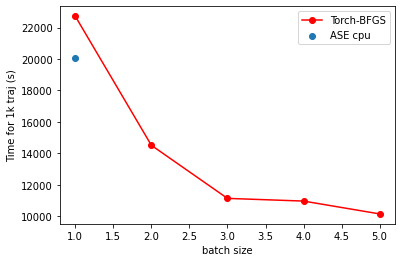

In [17]:
time_for_1k_traj = (1000/batch_size)*time_batch
import matplotlib.pyplot as plt

plt.plot(batch_size, time_for_1k_traj, '-ro', label="Torch-BFGS")
plt.scatter([1], [1000*20.08], label="ASE cpu")
plt.xlabel("batch size")
plt.ylabel("Time for 1k traj (s)")
plt.legend()

In [ ]:
executor = submitit.AutoExecutor(folder=args.logdir / "%j")
executor.update_parameters(
    name=config["identifier"],
    mem_gb=args.slurm_mem,
    timeout_min=args.slurm_timeout * 60,
    slurm_partition=args.slurm_partition,
    gpus_per_node=args.num_gpus,
    cpus_per_task=(args.num_workers + 1),
    tasks_per_node=(args.num_gpus if args.distributed else 1),
    nodes=args.num_nodes,
    additional_parameters={"begin": f"now+{args.begin*3600}"},
)

In [ ]:
f = open("/checkpoint/electrocatalysis/relaxations/mapping/final_splits_with_adbulk_ids/S2EF_filteredv2/val_is.txt", "r")
valids = f.read().splitlines()
import shutil

In [ ]:
for i in tqdm(valids[:10000]):
    path = i.split(",")[0]
    shutil.copy(path, "/private/home/mshuaibi/ocp_10k_val/")

In [ ]:
import pickle
import random

In [ ]:
k = open("/private/home/mshuaibi/baselines/expts/eval_expt/eval_results.pkl", "rb")

In [ ]:
evals = pickle.load(k)
key_len = len(evals.keys())

In [ ]:
(0.04785+0.05556+0.05839)/3

In [ ]:
trials_energy = []
trials_forces = []
val_sizes = range(100000, 10000000, 100000)
for valsize in tqdm(val_sizes):
    val_iter_energy = []
    val_iter_forces = []
    for k in range(100):
        samples = random.sample(range(key_len), int(valsize/128))

        energy_cmlt = []
        force_cmlt = []
        for i in samples:
            e_mae = evals[i]['potential energy/mae']
            fx = evals[i]['force_x/mae']
            fy = evals[i]['force_y/mae']
            fz = evals[i]['force_z/mae']
            favg = (fx+fy+fz)/3
            energy_cmlt.append(e_mae)
            force_cmlt.append(favg)

        val_energy = np.mean(energy_cmlt)
        val_forces = np.mean(force_cmlt)
        
        val_iter_energy.append(val_energy)
        val_iter_forces.append(val_forces)
        
    val_avg_energy = np.std(val_iter_energy)
    val_avg_forces = np.std(val_iter_forces)
    
    trials_energy.append(val_avg_energy)
    trials_forces.append(val_avg_forces)

In [ ]:
plt.plot(val_sizes, trials_forces)
plt.xlabel("Val Size")
plt.ylabel("Stdev, eV/A")
plt.title("Forces")
# plt.xscale("log")

In [ ]:
plt.plot(val_sizes, trials_energy)
plt.xlabel("Val Size")
plt.ylabel("Stdev, eV")
plt.title("Energy")
# plt.xscale("log")